In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
import random
from data_prep import prepare_datasets, get_dfs

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_absolute_error

seed = 42
random.seed(seed)
np.random.seed(seed)

LABELS = {0: "clear",
          1: "light cloud",
          2: "overcast",
          3: "light rain",
          4: "heavy rain",
          5: "storm"}

# Read Data

In [2]:
if op.exists(op.join("data", "train.csv")) and op.exists(op.join("data", "val.csv")) and op.exists(op.join("data", "test.csv")):
    train_df = pd.read_csv(op.join("data","train.csv"))
    val_df = pd.read_csv(op.join("data","val.csv"))
    test_df = pd.read_csv(op.join("data","test.csv"))
else:
    train_df, val_df, test_df = prepare_datasets(op.join("data","weather.csv"))
df_dct = {"train": train_df, "val": val_df, "test": test_df}
df_timed_dct = get_dfs(df_dct)

Creating dataset for time_offset=5
Creating dataset for time_offset=10
Creating dataset for time_offset=15
Creating dataset for time_offset=30
Creating dataset for time_offset=60


In [3]:
from data_prep import clean_dataframe, create_processed_frame
data = pd.read_csv("data/weather.csv")
if "Unnamed: 58" in data.columns:
    data = data.drop(["Unnamed: 58"], axis=1)
cleaned_df = clean_dataframe(data)
processed_df = create_processed_frame(cleaned_df)

# drops duplicates ignoring NA
temp_na_token = -999
processed_df[processed_df.isna()] = temp_na_token
ignored_cols = ["M_SESSION_UID", "TIMESTAMP"]
processed_df = processed_df.drop_duplicates(
    subset=[col for col in processed_df.columns if col not in ignored_cols])
processed_df[processed_df == temp_na_token] = pd.NA

train_ratio=0.7
val_ratio=0.2
session_uids = list(set(processed_df["M_SESSION_UID"]))
random.shuffle(session_uids)
train_uids, val_uids, test_uids = np.split(session_uids, [int(len(session_uids)*train_ratio),
                                                            int(len(session_uids)*(train_ratio+val_ratio))])
train_df = processed_df[[
    uid in train_uids for uid in processed_df["M_SESSION_UID"]]]
val_df = processed_df[[
    uid in val_uids for uid in processed_df["M_SESSION_UID"]]]
test_df = processed_df[[
    uid in test_uids for uid in processed_df["M_SESSION_UID"]]]


/kuacc/apps/anaconda/3.6/envs/root_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 104964/104964 [01:35<00:00, 1097.62it/s]


In [4]:
def add_flag_info(processed_dset, original_dset):
    ls = []
    for i in range(len(processed_dset)):
        sess_uid, ts = processed_dset[["M_SESSION_UID", "TIMESTAMP"]].iloc[i]
        flags = set(original_dset[(original_dset["M_SESSION_UID"]==sess_uid) & (original_dset["TIMESTAMP"]==ts)]["M_ZONE_FLAG"].dropna())
        ls.append([1 if f in flags else 0 for f in [1,2,3,4]])
    processed_dset[["IS_GREEN_FLAG_UP","IS_BLUE_FLAG_UP","IS_YELLOW_FLAG_UP","IS_RED_FLAG_UP"]] = ls
    return processed_dset



In [ ]:
for time_offset in df_timed_dct:
    print(time_offset)
    for k in df_timed_dct[time_offset]:
        table = df_timed_dct[time_offset][k]
        print(k, table.shape)
    print()

## Class Distribution

In [13]:
def plot_class_histograms_to_row(axs, df_timed_dct_single_time, time_offset, max_class_idx=6):
    """Takes a dict for single time_offset"""

    y_train = df_timed_dct_single_time['train']["TARGET_WEATHER"].to_numpy()
    y_val = df_timed_dct_single_time['val']["TARGET_WEATHER"].to_numpy()
    y_test = df_timed_dct_single_time['test']["TARGET_WEATHER"].to_numpy()
    y_all = np.concatenate([y_train,y_val,y_test])   
    
    axs[0].hist(y_all, bins=np.arange(max_class_idx+1), label='Total')
    axs[1].hist(y_train, bins=np.arange(max_class_idx+1), label='Train', color='g')
    axs[2].hist(y_val, bins=np.arange(max_class_idx+1), label='Val', color='b')
    axs[3].hist(y_test, bins=np.arange(max_class_idx+1), label='Test', color='y')

    for ax in axs:
        ax.set_xlabel('Classes', fontsize=13)
        ax.set_ylabel('Counts', fontsize=13)
        ax.set_xticks(np.arange(max_class_idx+1))
        ax.legend(loc=1, fontsize=13)

def plot_class_histograms(df_timed_dct, max_classes=7):
    fig, axs = plt.subplots(5, 4, figsize=(15,16), constrained_layout=True)
    fig.suptitle('Class Histograms of Each Time Step')
    for i, (time_offset, df_timed_dct_single_time) in enumerate(df_timed_dct.items()):
        plot_class_histograms_to_row(axs[i], df_timed_dct_single_time, time_offset, max_classes)
    plt.show()
    return fig

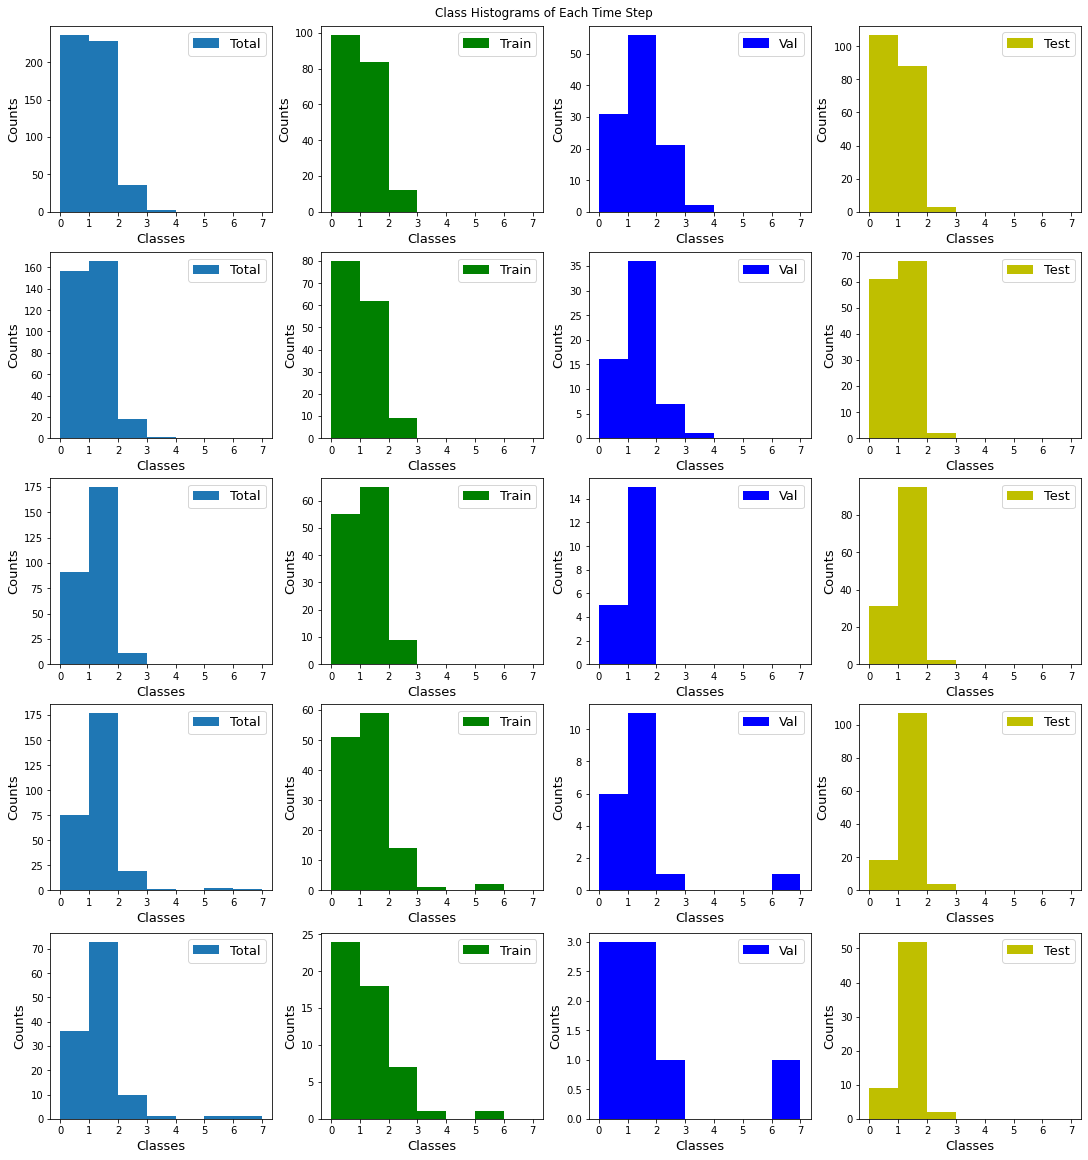

In [14]:
fig = plot_class_histograms(_df_timed_dct)
#fig.savefig('Weather_Classes-Before.jpeg')

2, 2, 1

In [26]:
# Drop the rows with low accuring target weather classes
# 3 seems like will be enough
CLASS_IDX_BOUNDARY = 3

import copy
_df_timed_dct = copy.deepcopy(df_timed_dct)

df_timed_dct_subset = {}
for time_offset, df_timed in _df_timed_dct.items():
    df_timed_dct_subset[time_offset] = {}
    for typ, d_set in df_timed.items():
        df_timed_dct_subset[time_offset][typ] = d_set[d_set['TARGET_WEATHER']<=CLASS_IDX_BOUNDARY].copy()

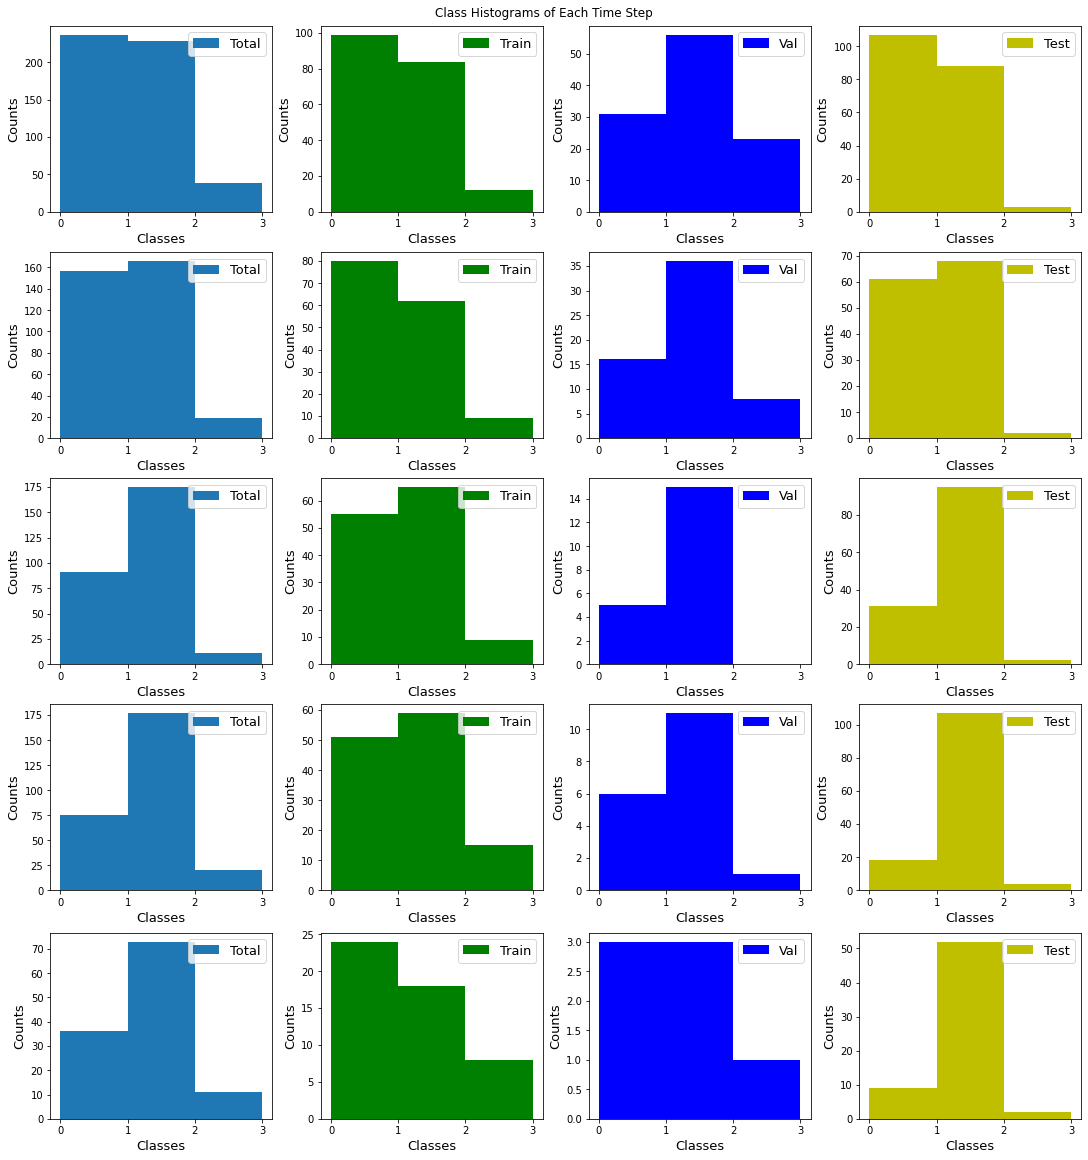

In [27]:
fig = plot_class_histograms(df_timed_dct_subset, max_classes=CLASS_IDX_BOUNDARY)
#fig.savefig('Weather_Classes-After.jpeg')

## Weather

In [22]:
def get_predict(dfs, model, problem_name, target_col, drop_cols, metric_func):
    X_train = dfs["train"].drop(drop_cols, axis=1) # remove annoying warnings
    y_train = dfs["train"][target_col].to_numpy().reshape(-1)
    X_val = dfs["val"].drop(drop_cols, axis=1)
    y_val = dfs["val"][target_col].to_numpy().reshape(-1)
    X_test = dfs["test"].drop(drop_cols, axis=1)
    y_test = dfs["test"][target_col].to_numpy().reshape(-1)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)   
    #print(problem_name)
    return metric_func(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test)

In [23]:
def get_classification_metrics(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, verbose=False):
    
    # Find exactly which classes are in each set
    train_classes = np.unique(np.concatenate((y_train, y_pred_train))).astype('int32')
    val_classes = np.unique(np.concatenate((y_val, y_pred_val))).astype('int32')
    test_classes = np.unique(np.concatenate((y_test, y_pred_test))).astype('int32')
    # Deal with class imbalances
    max_class_id = np.max([np.max(train_classes),np.max(val_classes),np.max(test_classes)])
    
    # Calculate scores 
    #train_acc = accuracy_score(y_train, y_pred_train)
    train_prec, train_rec, train_f1, train_sup = precision_recall_fscore_support(y_train, y_pred_train)
    #val_acc = accuracy_score(y_val, y_pred_val)
    val_prec, val_rec, val_f1, val_sup = precision_recall_fscore_support(y_val, y_pred_val)    
    #test_acc = accuracy_score(y_test, y_pred_test)
    test_prec, test_rec, test_f1, test_sup = precision_recall_fscore_support(y_test, y_pred_test) 
    
    print(train_prec.shape, val_prec.shape, test_prec.shape)
    print(train_rec.shape, val_rec.shape, test_rec.shape)
    print(train_f1.shape, val_f1.shape, test_f1.shape)
    print()
    
    train_prec_full = np.zeros((max_class_id+1,))
    train_rec_full = np.zeros((max_class_id+1,))
    train_f1_full = np.zeros((max_class_id+1,))
    train_prec_full[train_classes] = train_prec
    train_rec_full[train_classes] = train_rec
    train_f1_full[train_classes] = train_f1
    
    val_prec_full = np.zeros((max_class_id+1,))
    val_rec_full = np.zeros((max_class_id+1,))
    val_f1_full = np.zeros((max_class_id+1,))
    val_prec_full[val_classes] = val_prec
    val_rec_full[val_classes] = val_rec
    val_f1_full[val_classes] = val_f1 
    
    test_prec_full = np.zeros((max_class_id+1,))
    test_rec_full = np.zeros((max_class_id+1,))
    test_f1_full = np.zeros((max_class_id+1,))
    test_prec_full[test_classes] = test_prec
    test_rec_full[test_classes] = test_rec
    test_f1_full[test_classes] = test_f1    
    
    prec = np.stack([train_prec_full,val_prec_full,test_prec_full])
    rec = np.stack([train_rec_full,val_rec_full,test_rec_full])
    f1 = np.stack([train_f1_full,val_f1_full,test_f1_full])
    
    #classes = [train_classes,val_classes,test_classes]
    
    return prec, rec, f1, max_class_id
    
    if verbose:
        print("Train Acc: {}".format(train_acc))
        print("Train F1: {}".format(train_f1))    
        print("Val Acc: {}".format(val_acc))
        print("Val F1: {}".format(val_f1))
        print("Test Acc: {}".format(test_acc))
        print("Test F1: {}\n".format(test_f1))  
    
    #return accuracies, precisions, recalls, f1_scores, supports, classes  

def get_regression_metrics(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test):
    print("Train MAE: {}".format(mean_absolute_error(y_train, y_pred_train)))
    #print("Train MAPE: {}%".format(mean_absolute_percentage_error(y_train, y_pred_train) * 100))
    print("Val MAE: {}".format(mean_absolute_error(y_val, y_pred_val)))
    #print("Val MAPE: {}%".format(mean_absolute_percentage_error(y_val, y_pred_val) * 100))
    print("Test MAE: {}".format(mean_absolute_error(y_test, y_pred_test)))
    #print("Test MAPE Percantage: {}%".format(mean_absolute_percentage_error(y_test, y_pred_test) * 100))
    print()

In [24]:
def plot_scores_to_ax(ax, precisions, recalls, f1_scores, max_class_id, time_offset):
    
    ax[0].set_title('{} Min\nPrecision Scores'.format(time_offset))
    ax[0].bar(np.arange(len(precisions[0]))-0.2, precisions[0], 0.2, label='Train')
    ax[0].bar(np.arange(len(precisions[1])), precisions[1], 0.2, label='Val')
    ax[0].bar(np.arange(len(precisions[2]))+0.2, precisions[2], 0.2, label='Test')
    #ax[0].set_xticks(np.arange(max_class_id))
    #ax[0].set_xticks(classes[0])  
    ax[0].set_xlabel('Sets')
    ax[0].set_ylabel('Scores')

    ax[1].set_title('{} Min\nf1 Scores'.format(time_offset))
    ax[1].bar(np.arange(len(f1_scores[0]))-0.2, f1_scores[0], 0.2, label='Train')
    ax[1].bar(np.arange(len(f1_scores[1])), f1_scores[1], 0.2, label='Val')
    ax[1].bar(np.arange(len(f1_scores[2]))+0.2, f1_scores[2], 0.2, label='Test')
    #ax[1].set_xticks(np.arange(max_class_id))
    #ax[1].set_xticks(classes[1]) 
    ax[1].set_xlabel('Sets')
    ax[1].set_ylabel('Scores')    

    ax[2].set_title('{} Min\nRecall Scores'.format(time_offset))
    ax[2].bar(np.arange(len(recalls[0]))-0.2, recalls[0], 0.2, label='Train')
    ax[2].bar(np.arange(len(recalls[1])), recalls[1], 0.2, label='Val')
    ax[2].bar(np.arange(len(recalls[2]))+0.2, recalls[2], 0.2, label='Test')
    #ax[2].set_xticks(np.arange(max_class_id))
    #ax[2].set_xticks(classes[2])    
    ax[2].set_xlabel('Sets')
    ax[2].set_ylabel('Scores')    
    
    for i, x in enumerate(ax.flatten()):
        x.grid()
        x.legend(loc="lower right")
        x.set_yticks(np.arange(0, 1.1, 0.1))
        #x.set_xlim([-0.4,classes[i].max()+0.4])
    return

def plot_model_performance(model, data, save=False):
    fig, ax = plt.subplots(5,3,figsize=(15,16), constrained_layout=True)
    title = "{} Performances".format(type(model).__name__)
    fig.suptitle(title)
    for i, (time_offset, data_time) in enumerate(data.items()):
        precisions, recalls, f1_scores, max_class_id = get_predict(data_time,
                                                                    model, 
                                                                    f"Weather {time_offset} Min",
                                                                    ["TARGET_WEATHER"],
                                                                    ["TARGET_WEATHER", "TARGET_RAIN_PERCENTAGE"],
                                                                    get_classification_metrics)   
    
        plot_scores_to_ax(ax[i], precisions, recalls, f1_scores, max_class_id, time_offset)
    plt.show()
    if save:
        fig.savefig(f'{title}.jpeg')

## Random Forest

/kuacc/users/udemir15/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(3,) (4,) (3,)
(3,) (4,) (3,)
(3,) (4,) (3,)



/kuacc/users/udemir15/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(3,) (4,) (3,)
(3,) (4,) (3,)
(3,) (4,) (3,)

(3,) (2,) (3,)
(3,) (2,) (3,)
(3,) (2,) (3,)



/kuacc/users/udemir15/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(4,) (3,) (3,)
(4,) (3,) (3,)
(4,) (3,) (3,)



/kuacc/users/udemir15/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(4,) (3,) (3,)
(4,) (3,) (3,)
(4,) (3,) (3,)



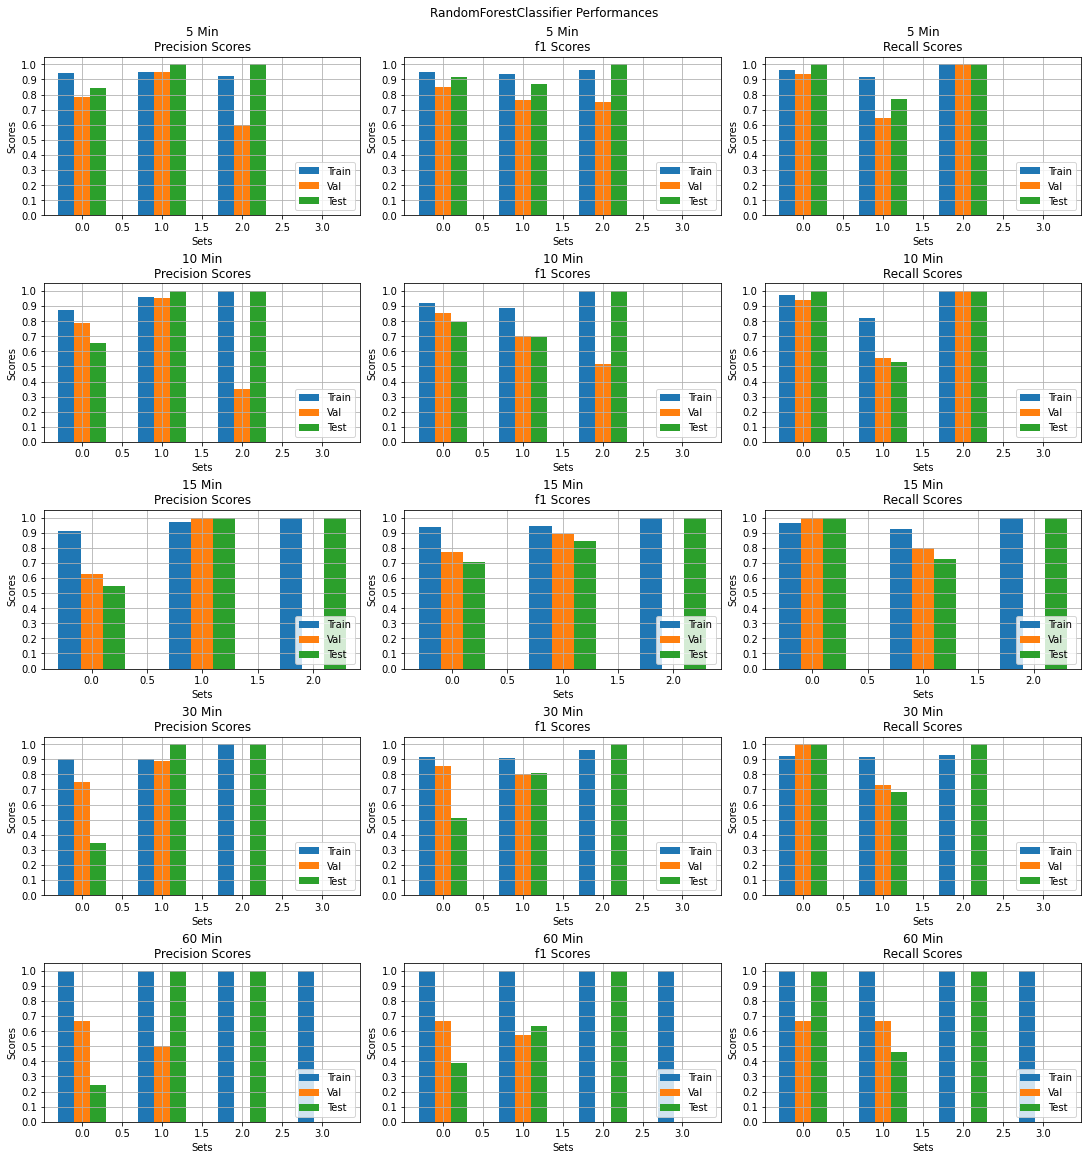

In [25]:
model = RandomForestClassifier(max_depth=5, random_state=0)
plot_model_performance(model, df_timed_dct_subset, save=False)

## K-NN

In [ ]:
K = 3

fig, ax = plt.subplots(5,3,figsize=(15,16), constrained_layout=True)
fig.suptitle("KNeighborsClassifier Performances for K={}".format(K))
for i, time_offset in enumerate(df_timed_dct):
    model = KNeighborsClassifier(K)
    precisions, recalls, f1_scores, max_class_id = get_predict(df_timed_dct[time_offset],
                                                                model, 
                                                                f"Weather {time_offset} Min",
                                                                ["TARGET_WEATHER"],
                                                                ["TARGET_WEATHER", "TARGET_RAIN_PERCENTAGE"],
                                                                get_classification_metrics)
    plot_scores_to_ax(ax[i], precisions, recalls, f1_scores, max_class_id, time_offset)
#fig.savefig('RandomForestClassifier.jpeg')    
plt.show()    

fig, ax = plt.subplots(5,3,figsize=(15,16), constrained_layout=True)
fig.suptitle("RandomForestClassifier Performances")
for i, time_offset in enumerate(df_timed_dct):
    model = RandomForestClassifier(max_depth=10, random_state=0)
    precisions, recalls, f1_scores, max_class_id = get_predict(df_timed_dct[time_offset],
                                                                    model, 
                                                                    f"Weather {time_offset} Min",
                                                                    ["TARGET_WEATHER"],
                                                                    ["TARGET_WEATHER", "TARGET_RAIN_PERCENTAGE"],
                                                                    get_classification_metrics)
    
    plot_scores_to_ax(ax[i], precisions, recalls, f1_scores, max_class_id, time_offset)
#fig.savefig('RandomForestClassifier.jpeg')    
plt.show()    

## RAIN_PERCENTAGE

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=10, random_state=0)
for time_offset in df_timed_dct:
    get_predict(df_timed_dct[time_offset], model, f"Weather {time_offset} Min", ["TARGET_RAIN_PERCENTAGE"], 
                ["TARGET_WEATHER","TARGET_RAIN_PERCENTAGE"], get_regression_metrics)